In [1]:
import pandas as pd

In [2]:
lgb = pd.read_csv('subs/lgb_944.csv')
cat = pd.read_csv('subs/catboost_944.csv')

In [7]:
mean = lgb
mean['lgb'] = lgb['target']
mean['cat'] = cat['target']

In [9]:
mean['mean'] = mean['lgb'] * 0.5 + mean['cat'] * 0.5
mean

,order_id,target,lgb,cat,mean
0,1350922,0.012709,0.012709,0.018946,0.015827
1,1354989,0.038541,0.038541,0.035863,0.037202
2,1352637,0.313552,0.313552,0.321680,0.317616
3,1350050,0.174687,0.174687,0.223645,0.199166
4,1341733,0.006096,0.006096,0.012271,0.009183
...,...,...,...,...,...
17191,1358397,0.144696,0.144696,0.209591,0.177143
17192,1357968,0.016355,0.016355,0.019584,0.017969
17193,1358835,0.989684,0.989684,0.990435,0.990059
17194,1365692,0.124545,0.124545,0.144454,0.134499


In [10]:
mean[['order_id', 'mean']].to_csv('lgb_cat_50_50.csv', index=False)


In [1]:
import pandas as pd
import numpy as np

def create_time_features(df, order_time_col='order_create_time', session_end_col='session_end_time'):
    """
    Создает новые временные признаки на основе колонок с временными метками.
    
    Параметры:
    df - DataFrame с данными
    order_time_col - название колонки с временем создания заказа (timestamp)
    session_end_col - название колонки с временем окончания сессии (timestamp)
    
    Возвращает:
    DataFrame с добавленными новыми признаками
    """
    # Создаем копию DataFrame чтобы избежать предупреждений
    df = df.copy()
    
    # Преобразуем колонки в datetime, если они еще не в этом формате
    df[order_time_col] = pd.to_datetime(df[order_time_col])
    df[session_end_col] = pd.to_datetime(df[session_end_col])
    
    # 1. Разница между окончанием сессии и созданием заказа (в секундах)
    df['time_to_order_seconds'] = (df[session_end_col] - df[order_time_col]).dt.total_seconds()
    
    # 2. Признаки времени создания заказа
    df['order_hour'] = df[order_time_col].dt.hour
    df['order_day_of_week'] = df[order_time_col].dt.dayofweek  # 0-понедельник, 6-воскресенье
    df['order_day_of_month'] = df[order_time_col].dt.day
    df['order_month'] = df[order_time_col].dt.month
    df['order_week_of_year'] = df[order_time_col].dt.isocalendar().week
    df['order_is_weekend'] = df[order_time_col].dt.dayofweek >= 5
    
    # 3. Признаки времени окончания сессии
    df['session_end_hour'] = df[session_end_col].dt.hour
    df['session_end_day_of_week'] = df[session_end_col].dt.dayofweek
    df['session_end_day_of_month'] = df[session_end_col].dt.day
    df['session_end_month'] = df[session_end_col].dt.month
    df['session_end_week_of_year'] = df[session_end_col].dt.isocalendar().week
    df['session_end_is_weekend'] = df[session_end_col].dt.dayofweek >= 5
    
    # 4. Разница во времени в разных единицах
    df['time_to_order_minutes'] = df['time_to_order_seconds'] / 60
    df['time_to_order_hours'] = df['time_to_order_seconds'] / 3600
    
    # 5. Временные категории (утро/день/вечер/ночь)
    bins = [-1, 6, 12, 18, 23]
    labels = ['night', 'morning', 'afternoon', 'evening']
    df['order_time_of_day'] = pd.cut(df['order_hour'], bins=bins, labels=labels)
    df['session_end_time_of_day'] = pd.cut(df['session_end_hour'], bins=bins, labels=labels)
    
    # 6. Является ли заказ сделан в тот же день, что и сессия
    df['same_day_order'] = df[order_time_col].dt.date == df[session_end_col].dt.date
    
    # 7. Сезонность (времена года)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    
    df['order_season'] = df['order_month'].apply(get_season)
    df['session_end_season'] = df['session_end_month'].apply(get_season)
    
    return df

In [2]:
import pickle
import joblib
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Загрузка LightGBM (из pickle)
with open('models/lgb_944.pkl', 'rb') as f:
    lgb_model = pickle.load(f)  # или joblib.load(f), в зависимости от способа сохранения

# Загрузка CatBoost (нативный формат)
cb_model = CatBoostClassifier()
cb_model.load_model('models/catboost_model.cbm')

In [4]:
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.target
tr = tr.drop(columns='target')

order_id = tst.order_id
tst = tst.drop(columns='order_id')


tr = create_time_features(tr)
tr = tr.drop(columns=['order_create_time', 'session_end_time'])

tst = create_time_features(tst)
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV


cat_cols = tr.select_dtypes(include=['category', 'object']).columns.tolist()
 
# Убедимся, что категории одинаковые
for col in cat_cols:
    tr[col] = tr[col].astype('category')
    tst[col] = tst[col].astype('category')

# Сохраняем категории, применим потом к тесту
cat_categories = {col: tr[col].cat.categories.tolist() for col in cat_cols}


# Явно задаем категории для всех колонок в трейн/валидации
for col in cat_cols:
    tr[col] = tr[col].cat.set_categories(cat_categories[col])
    tst[col] = tst[col].cat.set_categories(cat_categories[col])

# Сплит на тренировку и валидацию
X_train, X_val, y_train, y_val = train_test_split(tr, target, test_size=0.2, random_state=42, stratify=target)

for col in cat_cols:
    X_val[col] = X_val[col].cat.add_categories('missing').fillna('missing')
    tst[col] = tst[col].cat.add_categories('missing').fillna('missing')

# LightGBM предсказание
lgb_val_pred = lgb_model.predict(X_val)

# CatBoost предсказание
cb_val_pred = cb_model.predict_proba(X_val)[:, 1]

# Стэкинг: обучаем логистическую регрессию на предсказаниях
stack_input_train = np.column_stack([lgb_val_pred, cb_val_pred])
logreg = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=42)
logreg.fit(stack_input_train, y_val)

# Калибруем модель
calibrated_logreg = CalibratedClassifierCV(logreg, method='isotonic', cv=5)
calibrated_logreg.fit(stack_input_train, y_val)

# Предсказания на тесте
tst_lgb = tst.copy()
for col in cat_cols:
    tst_lgb[col] = pd.Categorical(tst_lgb[col], categories=cat_categories[col])

lgb_test_pred = lgb_model.predict(tst_lgb)
cb_test_pred = cb_model.predict_proba(tst)[:, 1]

# Стекинг
#stacked_pred = logreg.predict_proba(np.column_stack([lgb_test_pred, cb_test_pred]))[:, 1]
stacked_pred = calibrated_logreg.predict_proba(np.column_stack([lgb_test_pred, cb_test_pred]))[:, 1]

for col in cat_cols:
    X_train[col] = X_train[col].cat.add_categories('missing').fillna('missing')

# Предсказания базовых моделей на трейне
lgb_train_pred = lgb_model.predict(X_train)
cb_train_pred = cb_model.predict_proba(X_train)[:, 1]

# Стекинг предсказаний для трейна
#stacked_train_pred = logreg.predict_proba(np.column_stack([lgb_train_pred, cb_train_pred]))[:, 1]
stacked_train_pred = calibrated_logreg.predict_proba(np.column_stack([lgb_train_pred, cb_train_pred]))[:, 1]


# Расчет ROC-AUC
from sklearn.metrics import roc_auc_score

train_auc = roc_auc_score(y_train, stacked_train_pred)
print(f"ROC-AUC на трейне: {train_auc:.4f}")

# Дополнительно: оценка на валидации
#val_stacked_pred = logreg.predict_proba(stack_input_train)[:, 1]
val_stacked_pred = calibrated_logreg.predict_proba(stack_input_train)[:, 1]
val_auc = roc_auc_score(y_val, val_stacked_pred)
print(f"ROC-AUC на валидации: {val_auc:.4f}")

# Сохранение сабмита
submission = pd.DataFrame({
    'order_id': order_id,
    'target': stacked_pred
})
submission.to_csv('stacked_submission.csv', index=False)


ROC-AUC на трейне: 0.9643
ROC-AUC на валидации: 0.9574


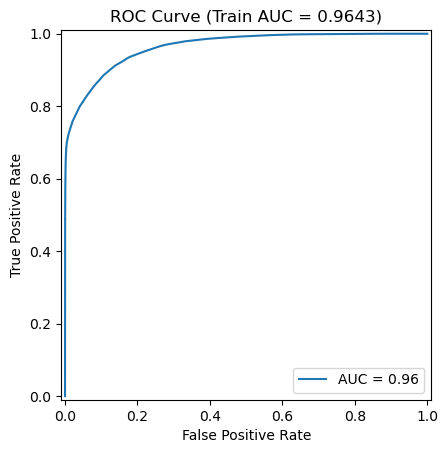

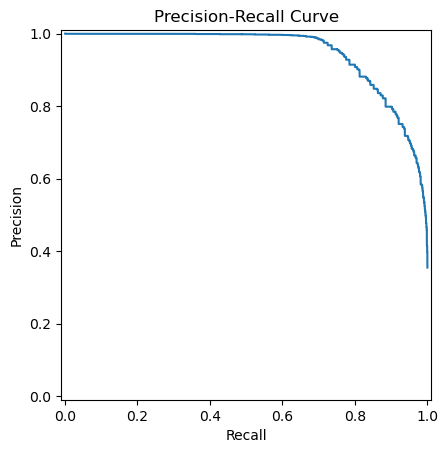

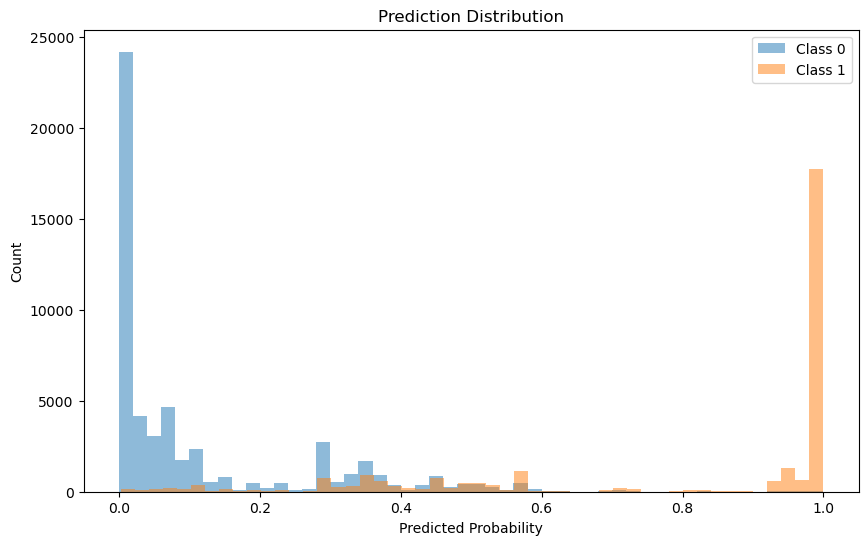

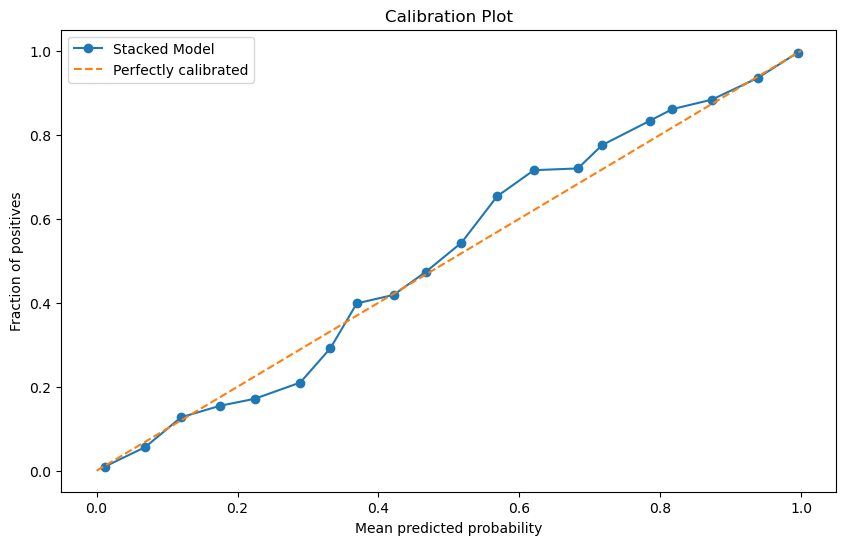

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay

# 1. ROC-кривая
fpr, tpr, _ = roc_curve(y_train, stacked_train_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=train_auc)
roc_display.plot()
plt.title(f'ROC Curve (Train AUC = {train_auc:.4f})')
plt.show()

# 2. Precision-Recall кривая
precision, recall, _ = precision_recall_curve(y_train, stacked_train_pred)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.title('Precision-Recall Curve')
plt.show()

# 3. Распределение предсказаний
plt.figure(figsize=(10, 6))
plt.hist(stacked_train_pred[y_train == 0], bins=50, alpha=0.5, label='Class 0')
plt.hist(stacked_train_pred[y_train == 1], bins=50, alpha=0.5, label='Class 1')
plt.title('Prediction Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

# 4. Калибровка предсказаний (для бинарной классификации)
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_train, stacked_train_pred, n_bins=20)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Stacked Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration Plot')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import brier_score_loss, log_loss

# Прогнозы и метки
y_pred = calibrated_logreg.predict_proba(stack_input_train)[:, 1]

# Метрики
print("Brier score:", brier_score_loss(y_val, y_pred))
print("Log loss:", log_loss(y_val, y_pred))


Brier score: 0.07270470846460451
Log loss: 0.23167985735033342
